# Goal

Use fastai-v2 and PyTorch to build an ImageSegmentation pipeline for a Kaggle challenge [TGS Salt Identification](https://www.kaggle.com/c/tgs-salt-identification-challenge/overview). The solution should be able to get you to top 1 - 5%. 

The solution is an update to my old [repo](https://github.com/svishnu88/TGS-SaltNet), which is based on fastai 0.7. 

Key Features of the notebook.

 *   Creating DataBlock (Dataset, Dataloader) 
 * Model
	* Create FastAI unet learner
	* Create a custom unet model demonstrating features like
		* Deep Supervision
		* Classifier branch
		* Hyper columns
 * Train on K-Fold
 * Ensemble by averaging
 * Loss function
	 * Classifier loss
	 * Loss for handling Deep supervision
	 * Segmentation loss
 * TTA - Horizontal Flip
 * Create Submission file.


#  Imports

In [1]:
from fastai2.vision.all import *
import fastai2

import pdb
import torchvision
from lovasz_losses import lovasz_hinge
from tqdm.notebook import tqdm
import cv2
from utils import *
from sklearn.model_selection import KFold

from networks import *

print(fastai2.__version__)


print(torch.__version__)

0.0.14
1.4.0


# Create Dataloader

In [2]:
path = Path('../data/train/')
test_path = Path("../data/test")
bs = 64
kf = 10
kfold = KFold(n_splits=kf, shuffle=True, random_state=42)
folds = list(kfold.split(X=range_of(get_image_files(path/'images'))))

In [3]:
def KFSplitter(fold_id,folds,**kwargs):
    def _inner(o,**kwargs):
        return folds[fold_id]

In [4]:
def get_data(fold_id,folds,size,bs):
    tfms = [IntToFloatTensor(div_mask=255),Rotate(4),Flip(),Brightness(0.1,p=0.25),Zoom(max_zoom=1.1,p=0.25)]
    db = DataBlock(blocks=(ImageBlock(),MaskBlock()),
                   batch_tfms=tfms,
                   splitter=KFSplitter(fold_id=fold_id,folds=folds),
                   item_tfms=[Resize(size)],
                   get_items=get_image_files,get_y=lambda o:str(o).replace('images','masks'))

    dls = db.dataloaders(path/'images',bs = bs)
    return dls
    

In [5]:
dls = get_data(fold_id=0,folds=folds,size=128,bs=32)
test_files = get_image_files(test_path)
test_dl = dls.test_dl(test_files)
test_dl_f = test_dl.new( after_batch=[*test_dl.after_batch,Flip(p=1.0)])

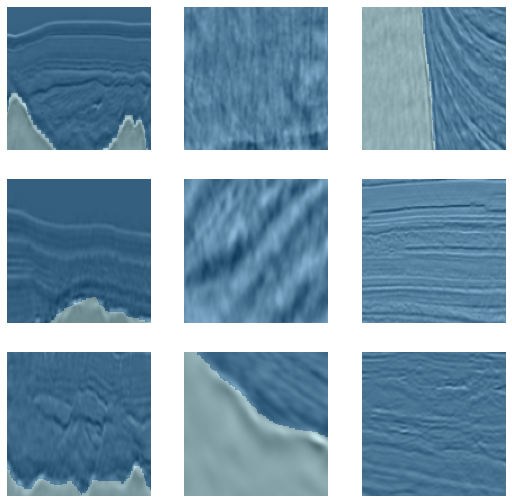

In [6]:
dls.show_batch()

# Models

## Try Unet Learner

In [29]:
dls = get_data(fold_id=0,folds=folds,size=224,bs=16)
dls.c=1
learn = unet_learner(dls, resnet34, loss_func=lovasz_hinge, metrics=[meanapv1])

In [30]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(20,wd=1e-7,lr_max=slice(1e-3))

## Create Model

### Unet Architecture

To learn more about Unet check the [paper](https://arxiv.org/abs/1505.04597).
![enter image description here](https://github.com/jarvislabsai/TGS-Salt-Identification-FastAI-V2/blob/master/images/unet-architecture.png?raw=true)

### Hyper column

To learn more about Unet check the [paper](https://arxiv.org/abs/1411.5752)
![enter image description here](https://github.com/jarvislabsai/TGS-Salt-Identification-FastAI-V2/blob/master/images/hypercolumns.png?raw=true)

### Deep supervision

To learn more about Deep supervision check the [paper](https://arxiv.org/abs/1505.02496)
![enter image description here](https://github.com/jarvislabsai/TGS-Salt-Identification-FastAI-V2/blob/master/images/Deep%20Supervision.png?raw=true)

### Custom Unet with Hypercolumn, Classifier & Deep supervision

In [8]:
class UnetWithAttention(Module):
    def __init__(self):
        self.rn = ResNetWithBAM()
        fs = 16
        self.up1 = TgsUnetBlock(512,256,fs)
        self.up2 = TgsUnetBlock(fs,128,fs)
        self.up3 = TgsUnetBlock(fs,64,fs)
        self.up4 = nn.ConvTranspose2d(fs, fs, 2, stride=2)

        self.img_class = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                   Flatten(),
                                   nn.Dropout(0.3),
                                   nn.Linear(512,256),nn.ReLU(inplace=True),nn.BatchNorm1d(256),
                                   nn.Dropout(0.3),
                                   nn.Linear(256,1),nn.Sigmoid()
                                )
        
        self.logit = nn.Sequential(nn.Conv2d(69,69,kernel_size=3,padding=1),nn.ReLU(inplace=True),
                           nn.Conv2d(69,1,kernel_size=1,padding=0))
        
        self.ds1,self.ds2,self.ds3,self.ds4,self.ds5 = [conv_block(fs,1) for _ in range(5)]
        
    def forward(self,img):
        e0,e1,e2,e3,e4 = self.rn(img)
        img_sz = img.size(2)     
        d1 = self.up1(e4, e3) 
        d2 = self.up2(d1, e2) 
        d3 = self.up3(d2, e1) 
        d4 = self.up4(d3) 

        #Creating hyper column features
        hyp_column = torch.cat([create_interpolate(o,img_sz) for o in [d1,d2,d3,d4]],1)
        
        #Creating features for deep supervision
        ds1,ds2,ds3,ds4 = self.ds1(d1),self.ds2(d2),self.ds3(d3),self.ds4(d4)
        
        ds = torch.cat([create_interpolate(o,img_sz) for o in [ds1,ds2,ds3,ds4]],1)
        
        #Image classifier
        img_class = self.img_class(e4)
        
        img_class_up = create_interpolate(img_class.view(img_class.size(0),-1,1,1),img_sz,'nearest',None)
        
        #Fuse Deep supervision features
        ds = torch.cat([hyp_column,ds,img_class_up],1)
        
        x = self.logit(ds)
        
        return (x[:,0],img_class,*[o[:,0] for o in [ds1,ds2,ds3,ds4]])
#     ,img_class,*[o[:,0] for o in [ds1,ds2,ds3,ds4]]

# Loss Function

In [9]:
def change_tensor_size(targ,sz):
    if targ.size(1) == sz:
        return targ
    targ_np = np.array([cv2.resize(o.astype('float32'),dsize=(sz,sz)) for o in to_np(targ)])
    return torch.tensor(targ_np,dtype=torch.float32,device=torch.device("cuda"))

In [10]:
def multi_lovasz_loss(logits,target):
    logit,cl_logit,ds1,ds2,ds3,ds4 = logits
    cl_targets = (Flatten()(target).sum(1) != 0).type(torch.cuda.FloatTensor).view(cl_logit.size(0),-1)
    non_empty_imgs = cl_targets.view(cl_logit.size(0),1,1)
    cl = F.binary_cross_entropy(cl_logit,cl_targets)
    rf_loss = lovasz_hinge(logit,target)
    
    #Handling deep supervised features
    for o in [ds1,ds2,ds3,ds4]:
        targ_rs = change_tensor_size(target,o.size(1))
        o = o * non_empty_imgs
        rf_loss += lovasz_hinge(o,targ_rs)
        
    return 0.05*cl+ rf_loss

# Training

In [ ]:
for fold_id in range(kf):
    dls = dls = get_data(fold_id=fold_id,folds=folds,size=224,bs=16)
    learn = Learner(dls,UnetWithAttention(),loss_func=multi_lovasz_loss,
                    lr=1e-3,
                    wd=1e-7,
                    metrics=[my_eval],
                    cbs=[SaveModelCallback(monitor='my_eval',comp=np.greater,fname="best_model")])
    learn.fit_one_cycle(100,slice(1e-3))
    learn.save(f'model-{fold_id}')

# Get Predictions

In [11]:
learn = Learner(dls,UnetWithAttention(),loss_func=multi_lovasz_loss,lr=1e-3,wd=1e-7,metrics=[my_eval])

In [13]:
def get_k_fold_preds(kf,sz=224):
    preds = np.zeros(shape = (18000,sz,sz))
    for fold_id in tqdm_notebook(range(kf)):
        learn.load(f'model-{fold_id}')
        test_preds = array(learn.get_preds(dl=test_dl)[0][0])
        with test_dl_f.dataset.set_split_idx(0):
            test_preds_f = array(learn.get_preds(dl=test_dl_f)[0][0])
        for i,im in enumerate(test_preds):preds[i]+= im
        for i,im in enumerate(test_preds_f):preds[i]+= np.fliplr(im)    
    return preds/kf*2        

In [ ]:
preds = get_k_fold_preds(kf)

In [23]:
preds_s=array(torch.sigmoid(tensor(preds)))

# Create submission file

In [24]:
p = [cv2.resize(o,dsize=(101,101)) for o in preds_s]
p = [(o>0.5).astype(np.uint8) for o in p]

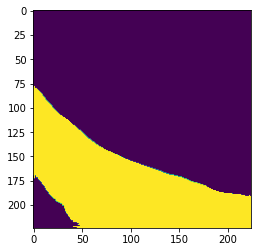

In [25]:
plt.imshow((preds[14]>0.5).astype(np.uint8))

In [26]:
pred_dict = {o.name.split('.')[0]:RLenc(p[i]) for i,o in enumerate(test_files)}
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')